# Unsupervised Learning Problem Description

## Background

Modern financial markets are driven by electronic order books, which aggregate buy (bid) and sell (ask) orders to facilitate price discovery and liquidity. These order books reflect real-time supply and demand dynamics. Analyzing this data is critical for understanding liquidity, price formation, and short-term market dynamics, particularly in highly volatile environments. However, order book data—especially Level 2 data, which includes multiple price and volume tiers—poses significant analytical challenges due to its high dimensionality, rapid update frequency, and inherent noise.

Principal Component Analysis (PCA) emerges as a powerful tool to address these challenges. As an unsupervised dimensionality reduction technique, PCA identifies orthogonal linear combinations of variables (principal components) that capture the maximum variance in the data. By projecting high-dimensional order book data onto a lower-dimensional subspace, PCA filters noise, mitigates multicollinearity, and extracts latent features that can make them valuable for forecasting.

Cryptocurrency markets, characterized by 24/7 trading, low latency, and open data, present unique opportunities for this analysis. For this project, I relied on raw data captured from Kraken, a leading cryptocurrency exchange, utilizing their robous websocket API. The data was captured with a Go lang program that saved the resulting messages to a JSONL file called "orderbook.jsonl".

## Problem Statement

This project investigates the application of Principal Component Analysis (PCA) to high-frequency Level 2 order book data of TRON (TRX) on the Kraken exchange, with the objective of forecasting short-term price movements. The project aims to address two core questions: First, can PCA effectively reduce the dimensionality of TRX's order book data while preserving predictive signals related to price dynamics? Second, do PCA-derived features, when integrated into a simple learning framework (in this case Linear Regression), outperform baseline models that use raw order book features?

# Exploratory Data Analysis

## Order Book Reconstruction

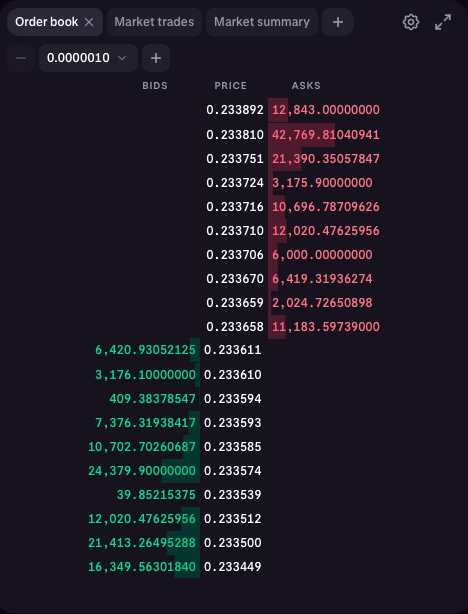

The image above shows a snapshot visualization of the Kraken orderbook for the TRON currency taken from the exchange site itself.

When connecting to the order book API on Kraken (and most other crypto exchanges) you don't actually recieve a full snapshot of the order book with each message. You recieve one single snapshot at the start and only recieve updates to that snapshot thereafter. Thus the first step of the data analysis process is to reconstruct order book snapshots from the update messages.

In [1]:
# Import the necessary packages to process and visualize the data

import plotly.express as px
import plotly
import plotly.io as pio
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import json

In [2]:
class OrderBook:
    def __init__(self):
        self.bids = {}
        self.asks = {}
        self.snapshots = []  # List to store snapshots of the order book

    def process_snapshot(self, updates):
        # Process a full snapshot message.
        for update in updates:
            self._update_side(update, 'bids')
            self._update_side(update, 'asks')
        self._truncate()
        self._save_snapshot(timestamp=updates[0].get("timestamp", None))

    def process_update(self, updates):
        # Process incremental update messages.
        for update in updates:
            self._update_side(update, 'bids')
            self._update_side(update, 'asks')
            self._truncate()
            # Use the timestamp from the update (if available) as the snapshot timestamp.
            timestamp = update.get("timestamp")
            self._save_snapshot(timestamp=timestamp)

    def _update_side(self, update, side):
        if side in update:
            for level in update[side]:
                price = float(level['price'])
                qty = float(level['qty'])
                book = self.bids if side == 'bids' else self.asks
                if qty == 0:
                    book.pop(price, None)
                else:
                    book[price] = qty

    def _truncate(self):
        # Keep only top 10 bids (highest first)
        self.bids = dict(sorted(self.bids.items(), key=lambda x: -x[0])[:10])
        # Keep only top 10 asks (lowest first)
        self.asks = dict(sorted(self.asks.items(), key=lambda x: x[0])[:10])

    def _save_snapshot(self, timestamp):
        # Save a snapshot of the current order book state along with the update timestamp.
        snapshot = {
            "timestamp": timestamp,
            "bids": sorted(self.bids.items(), key=lambda x: -x[0]),
            "asks": sorted(self.asks.items(), key=lambda x: x[0])
        }
        self.snapshots.append(snapshot)

    def __repr__(self):
        bids_sorted = sorted(self.bids.items(), key=lambda x: -x[0])
        asks_sorted = sorted(self.asks.items(), key=lambda x: x[0])
        return f"Bids:\n{bids_sorted}\n\nAsks:\n{asks_sorted}"

orderbook = OrderBook()

with open('orderbook.jsonl', 'r') as f:
    for line in f:
        msg = json.loads(line)
        if msg.get("channel") == "book":
            msg_type = msg.get("type")
            data = msg.get("data", [])
            if msg_type == "snapshot":
                orderbook.process_snapshot(data)
            elif msg_type == "update":
                orderbook.process_update(data)

print(orderbook) # This is just showing the final state of the orderbook after all updates were processed to help understand the data structure

Bids:
[(0.230085, 29723.40346245), (0.230063, 333.43900823), (0.230062, 1995.0), (0.230059, 3242.5), (0.230058, 10866.79443695), (0.230036, 3477.0137), (0.23003, 7434.67369004), (0.230025, 24778.7), (0.230009, 21738.26028633), (0.229974, 40.07116624)]

Asks:
[(0.230086, 44645.40859149), (0.230135, 6517.92019009), (0.230153, 333.10527318), (0.230154, 6000.0), (0.230171, 3241.8), (0.230174, 10861.38298493), (0.230202, 11923.87067187), (0.230213, 21719.08580969), (0.230214, 54951.55492), (0.230253, 16058.04034942)]


With the updates processed, we now a have a reconstructed orderbook snapshot from each message. This step also allowed us to filter out extranious messages such as "heartbeat" pings that simply serve to keep the websocket connection alive during inactive periods

In [3]:
print(f"Number of order book snapshots {len(orderbook.snapshots)}")
print(f"Individual Snapshot Keys: {orderbook.snapshots[0].keys()}")

#Confirm that all of our snapshots have 10 (price, qty) tuples for bids and asks
for i, snap in enumerate(orderbook.snapshots):
  if len(snap["bids"]) != 10:
    print(f"Error with bid len in snapshot {i}")
  elif len(snap["asks"]) != 10:
    print(f"Error with ask len in snapshot {i}")

Number of order book snapshots 23214
Individual Snapshot Keys: dict_keys(['timestamp', 'bids', 'asks'])


## Frequency Visualization

Now we can construct a timeseries view to better understand the distribution of update messages with respect to time.

In [4]:
def parse_timestamp(ts):
    # Convert the ISO timestamp string (without the trailing 'Z') to a datetime object.
    return datetime.fromisoformat(ts.rstrip("Z"))

# Aggregate snapshots per second.
snapshot_counts = Counter()
for snap in orderbook.snapshots:
    if snap["timestamp"]:
        # Truncate to second-level granularity.
        dt = parse_timestamp(snap["timestamp"]).replace(microsecond=0)
        snapshot_counts[dt] += 1

# Create a DataFrame from the snapshot counts.
data = pd.DataFrame({
    "timestamp": list(snapshot_counts.keys()),
    "count": list(snapshot_counts.values())
})

data = data.sort_values("timestamp")

fig = px.bar(data, x='timestamp', y='count', title='Snapshots per Second')

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="minute", stepmode="backward"),
                dict(count=5, label="5m", step="minute", stepmode="backward"),
                dict(step="all", label="All")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"  # Ensure x-axis is treated as date/time
    )
)
fig.update_traces(marker_color='darkblue')
fig.show()


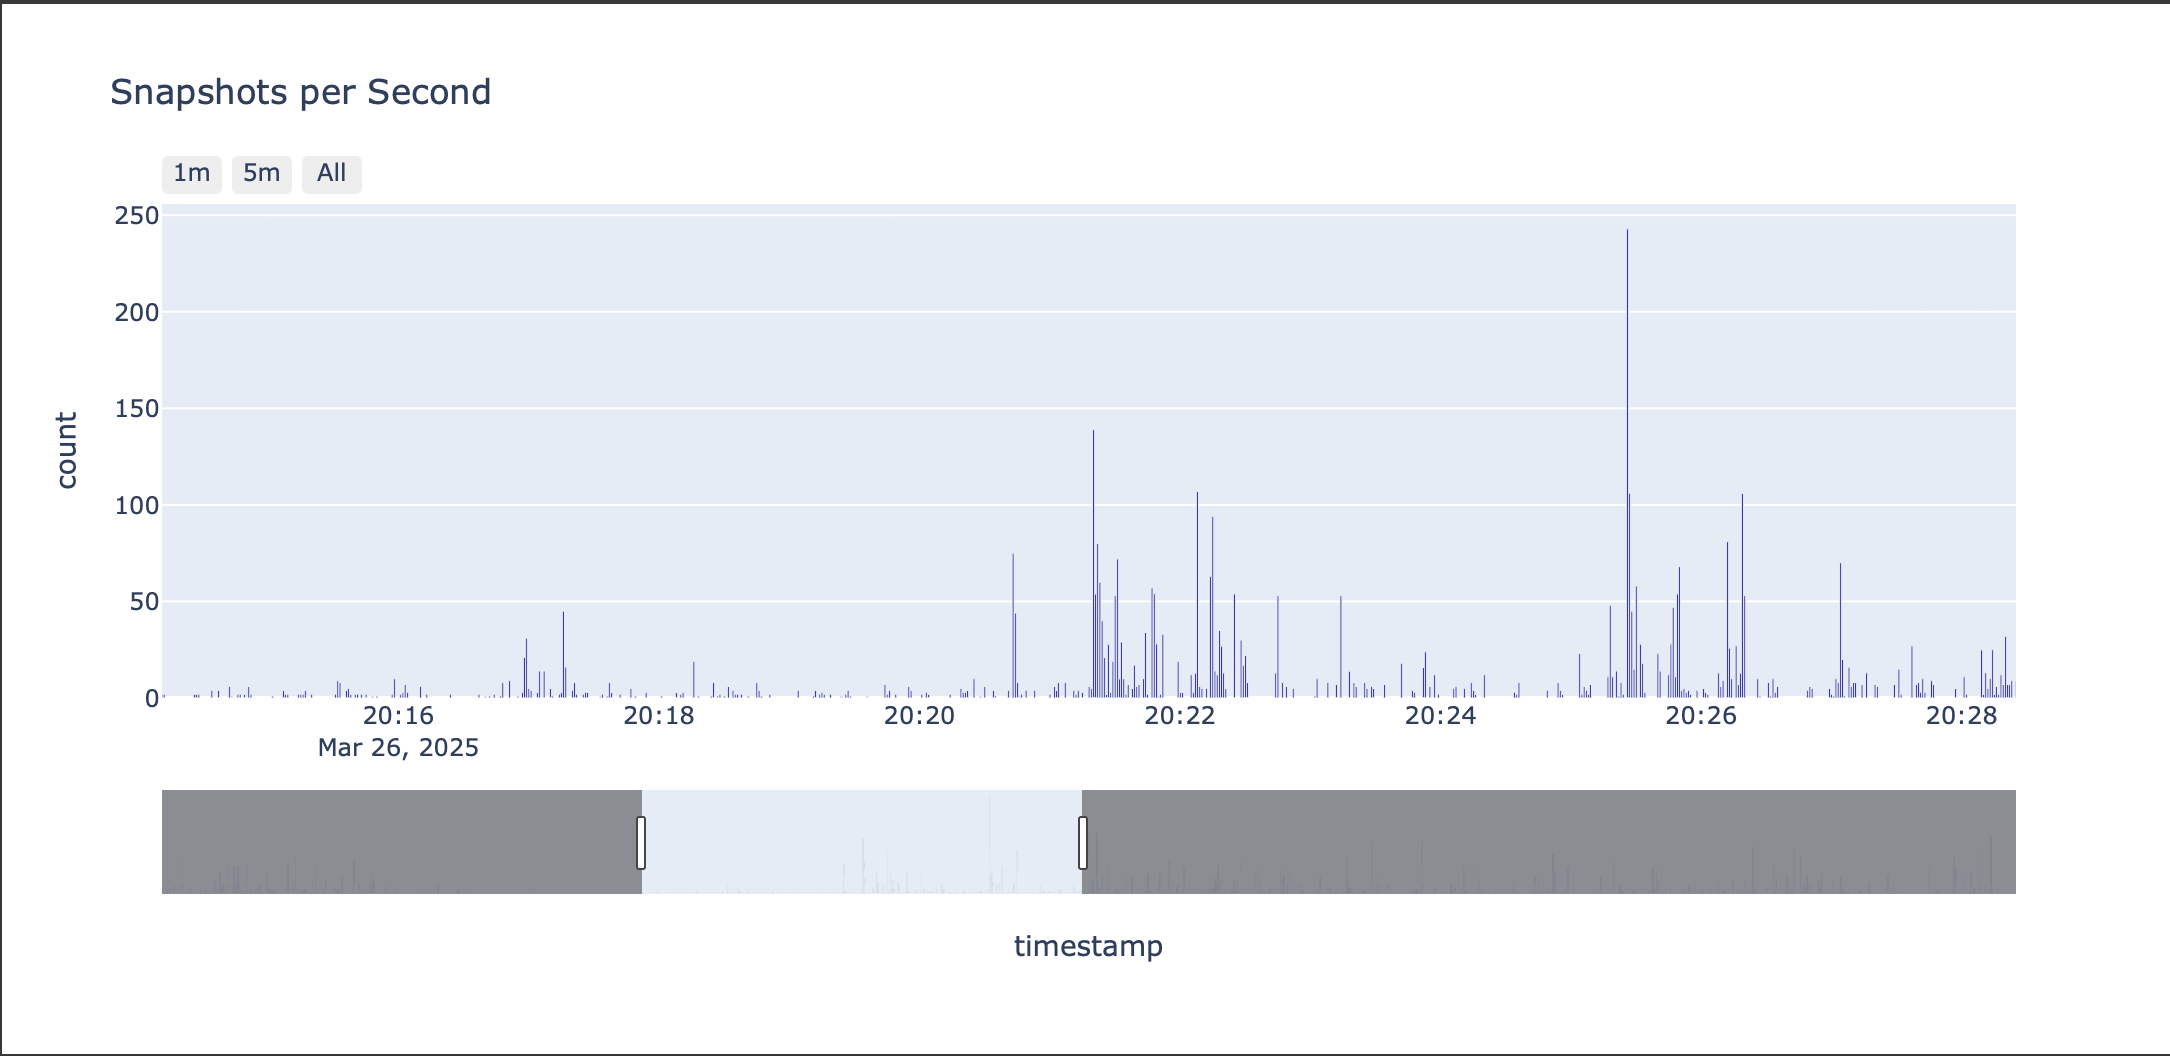

We can see that order book updates are "bursty" in nature with periods of relative calm interrupted by short spikes in the number of updates. This matches our intuition as updates to the order book would trigger other market participants to also update their sitting orders to not reflect the now stale prices.

## Reformatting data to Pandas DataFrame

Reformatting the data to a dataframe where each level's price and quantity is its own column will allow for easier transfromation into model features.

In [5]:
# First we convert the list of snapshots into a dataframe
df = pd.DataFrame(orderbook.snapshots)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
display(df)

bids  \
timestamp                                                                             
NaT                               [(0.229762, 336.1203122), (0.229761, 6528.5231...   
2025-03-26 19:58:40.407519+00:00  [(0.229762, 336.1203122), (0.229761, 6528.5231...   
2025-03-26 19:58:40.407572+00:00  [(0.229762, 336.1203122), (0.229761, 6528.5231...   
2025-03-26 19:58:40.410248+00:00  [(0.229762, 336.1203122), (0.229761, 6528.5231...   
2025-03-26 19:58:40.411155+00:00  [(0.229762, 336.1203122), (0.229755, 6528.6936...   
...                                                                             ...   
2025-03-26 20:58:36.607108+00:00  [(0.230085, 29723.40346245), (0.230063, 333.43...   
2025-03-26 20:58:36.629076+00:00  [(0.230085, 29723.40346245), (0.230063, 333.43...   
2025-03-26 20:58:37.418444+00:00  [(0.230085, 29723.40346245), (0.230063, 333.43...   
2025-03-26 20:58:37.418530+00:00  [(0.230085, 29723.40346245), (0.230063, 333.43...   
2025-03-26 20:58:37.421857+00:00  [(0.230085, 29723.40346245), (0.230063, 333.43...   

                                                                               asks  
timestamp                                                                            
NaT                               [(0.229818, 336.08071764), (0.229819, 6526.875...  
2025-03-26 19:58:40.407519+00:00  [(0.229818, 336.08071764), (0.229819, 6526.875...  
2025-03-26 19:58:40.407572+00:00  [(0.229818, 2331.08071764), (0.229819, 6526.87...  
2025-03-26 19:58:40.410248+00:00  [(0.229817, 336.37234187), (0.229818, 1995.0),...  
2025-03-26 19:58:40.411155+00:00  [(0.229817, 336.37234187), (0.229818, 1995.0),...  
...                                                                             ...  
2025-03-26 20:58:36.607108+00:00  [(0.230086, 44645.40859149), (0.23017, 333.399...  
2025-03-26 20:58:36.629076+00:00  [(0.230086, 44645.40859149), (0.230135, 6517.9...  
2025-03-26 20:58:37.418444+00:00  [(0.230086, 44645.40859149), (0.230135, 6517.9...  
2025-03-26 20:58:37.418530+00:00  [(0.230086, 44645.40859149), (0.230135, 6517.9...  
2025-03-26 20:58:37.421857+00:00  [(0.230086, 44645.40859149), (0.230135, 6517.9...  

[23214 rows x 2 columns]

In [6]:
# Next we define a function that allows us to unpack the bid and ask tuple lists into their own price
# and quantity columns per level i.e. bids_0_price, bids_0_qty, bids_1_price...

def expand_bids_asks(df, col, depth=10):
    """
    Expands bid/ask columns into separate columns for price and quantity
    up to the specified depth.

    Args:
        df: DataFrame containing 'bids' or 'asks' column.
        col: 'bids' or 'asks' string indicating which column to expand.
        depth: Maximum depth of the order book to extract.  Defaults to 10.

    Returns:
        DataFrame with expanded columns.
    """
    for i in range(depth):
        df[f'{col}_{i}_price'] = df[col].apply(lambda x: x[i][0] if isinstance(x, list) and len(x) > i else np.nan)
        df[f'{col}_{i}_qty'] = df[col].apply(lambda x: x[i][1] if isinstance(x, list) and len(x) > i else np.nan)
    return df

In [7]:
# Expand the 'bids' and 'asks' columns
df = expand_bids_asks(df, 'bids', depth=10)
df = expand_bids_asks(df, 'asks', depth=10)

df = df.drop(columns=['bids', 'asks'])

display(df)

bids_0_price    bids_0_qty  bids_1_price  \
timestamp                                                                    
NaT                                   0.229762    336.120312      0.229761   
2025-03-26 19:58:40.407519+00:00      0.229762    336.120312      0.229761   
2025-03-26 19:58:40.407572+00:00      0.229762    336.120312      0.229761   
2025-03-26 19:58:40.410248+00:00      0.229762    336.120312      0.229761   
2025-03-26 19:58:40.411155+00:00      0.229762    336.120312      0.229755   
...                                        ...           ...           ...   
2025-03-26 20:58:36.607108+00:00      0.230085  29723.403462      0.230063   
2025-03-26 20:58:36.629076+00:00      0.230085  29723.403462      0.230063   
2025-03-26 20:58:37.418444+00:00      0.230085  29723.403462      0.230063   
2025-03-26 20:58:37.418530+00:00      0.230085  29723.403462      0.230063   
2025-03-26 20:58:37.421857+00:00      0.230085  29723.403462      0.230063   

                                   bids_1_qty  bids_2_price   bids_2_qty  \
timestamp                                                                  
NaT                               6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.407519+00:00  6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.407572+00:00  6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.410248+00:00  6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.411155+00:00  6528.693608      0.229742  3375.800000   
...                                       ...           ...          ...   
2025-03-26 20:58:36.607108+00:00   333.439008      0.230062  1995.000000   
2025-03-26 20:58:36.629076+00:00   333.439008      0.230062  1995.000000   
2025-03-26 20:58:37.418444+00:00   333.439008      0.230062  1995.000000   
2025-03-26 20:58:37.418530+00:00   333.439008      0.230062  1995.000000   
2025-03-26 20:58:37.421857+00:00   333.439008      0.230062  1995.000000   

                                  bids_3_price   bids_3_qty  bids_4_price  \
timestamp                                                                   
NaT                                   0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.407519+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.407572+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.410248+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.411155+00:00      0.229727  11183.59739      0.229721   
...                                        ...          ...           ...   
2025-03-26 20:58:36.607108+00:00      0.230059   3242.50000      0.230058   
2025-03-26 20:58:36.629076+00:00      0.230059   3242.50000      0.230058   
2025-03-26 20:58:37.418444+00:00      0.230059   3242.50000      0.230058   
2025-03-26 20:58:37.418530+00:00      0.230059   3242.50000      0.230058   
2025-03-26 20:58:37.421857+00:00      0.230059   3242.50000      0.230058   

                                    bids_4_qty  ...  asks_5_price  \
timestamp                                       ...                 
NaT                               11183.597390  ...      0.229834   
2025-03-26 19:58:40.407519+00:00  11183.597390  ...      0.229847   
2025-03-26 19:58:40.407572+00:00  11183.597390  ...      0.229847   
2025-03-26 19:58:40.410248+00:00  11183.597390  ...      0.229834   
2025-03-26 19:58:40.411155+00:00   4352.244600  ...      0.229834   
...                                        ...  ...           ...   
2025-03-26 20:58:36.607108+00:00  10866.794437  ...      0.230202   
2025-03-26 20:58:36.629076+00:00  10866.794437  ...      0.230178   
2025-03-26 20:58:37.418444+00:00  10866.794437  ...      0.230202   
2025-03-26 20:58:37.418530+00:00  10866.794437  ...      0.230174   
2025-03-26 20:58:37.421857+00:00  10866.794437  ...      0.230174   

                                    asks_5_qty  asks_6_price    asks_6_qty  \
timestamp                                           

# Model Analysis

## Creating Prediction Target

We need something for our model to predict and a common option in financial markets is a markout price, a price at some predefined point in the future. That point could be some fixed time say 1 minute or in this case some fixed number of updates in the future. For this project I am going to markout to the order book midprice (calculated as (best bid + best ask)/2) 100 updates after the current update. From the previous frequency graph, we can see that updates are "bursty" in nature with long periods of quiet in between high update periods. The 100 update markout thus seeks to balance frequent predictive periods with a time period long enough to act upon. If for example, we chose to predict midmarket 10 updates away, those 10 updates may arrive while we are still trying to calculate a price prediction meaning our model would not be very helpful in a "real-world" environment.

In [8]:
df['mid'] = (df['bids_0_price'] + df['asks_0_price']) / 2
df['ret_100'] = df['mid'].shift(-100) - df['mid']
df.dropna(inplace=True) # Need to drop last rows that don't have 100 entries after them

In [9]:
display(df)

bids_0_price  bids_0_qty  bids_1_price  \
timestamp                                                                  
NaT                                   0.229762  336.120312      0.229761   
2025-03-26 19:58:40.407519+00:00      0.229762  336.120312      0.229761   
2025-03-26 19:58:40.407572+00:00      0.229762  336.120312      0.229761   
2025-03-26 19:58:40.410248+00:00      0.229762  336.120312      0.229761   
2025-03-26 19:58:40.411155+00:00      0.229762  336.120312      0.229755   
...                                        ...         ...           ...   
2025-03-26 20:57:51.448168+00:00      0.230067  333.433211      0.230066   
2025-03-26 20:57:51.542962+00:00      0.230067  333.433211      0.230066   
2025-03-26 20:57:51.546029+00:00      0.230067  333.433211      0.230066   
2025-03-26 20:57:51.893896+00:00      0.230067  333.433211      0.230066   
2025-03-26 20:58:00.826693+00:00      0.230067  333.433211      0.230066   

                                    bids_1_qty  bids_2_price   bids_2_qty  \
timestamp                                                                   
NaT                                6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.407519+00:00   6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.407572+00:00   6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.410248+00:00   6528.523117      0.229755  6528.693608   
2025-03-26 19:58:40.411155+00:00   6528.693608      0.229742  3375.800000   
...                                        ...           ...          ...   
2025-03-26 20:57:51.448168+00:00  23204.073650      0.230065  6519.896551   
2025-03-26 20:57:51.542962+00:00  23204.073650      0.230065  6519.896551   
2025-03-26 20:57:51.546029+00:00  23204.073650      0.230065  6519.896551   
2025-03-26 20:57:51.893896+00:00  23204.073650      0.230065  6519.896551   
2025-03-26 20:58:00.826693+00:00  23204.073650      0.230065  6519.896551   

                                  bids_3_price   bids_3_qty  bids_4_price  \
timestamp                                                                   
NaT                                   0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.407519+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.407572+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.410248+00:00      0.229742   3375.80000      0.229727   
2025-03-26 19:58:40.411155+00:00      0.229727  11183.59739      0.229721   
...                                        ...          ...           ...   
2025-03-26 20:57:51.448168+00:00      0.230063  23204.07365      0.230062   
2025-03-26 20:57:51.542962+00:00      0.230063  11183.59739      0.230062   
2025-03-26 20:57:51.546029+00:00      0.230062   1995.00000      0.230059   
2025-03-26 20:57:51.893896+00:00      0.230062   1995.00000      0.230059   
2025-03-26 20:58:00.826693+00:00      0.230062   1995.00000      0.230059   

                                   bids_4_qty  ...  asks_6_price  \
timestamp                                      ...                 
NaT                               11183.59739  ...      0.229847   
2025-03-26 19:58:40.407519+00:00  11183.59739  ...      0.229865   
2025-03-26 19:58:40.407572+00:00  11183.59739  ...      0.229865   
2025-03-26 19:58:40.410248+00:00  11183.59739  ...      0.229847   
2025-03-26 19:58:40.411155+00:00   4352.24460  ...      0.229847   
...                                       ...  ...           ...   
2025-03-26 20:57:51.448168+00:00   1995.00000  ...      0.230170   
2025-03-26 20:57:51.542962+00:00   1995.00000  ...      0.230170   
2025-03-26 20:57:51.546029+00:00   3242.50000  ...      0.230170   
2025-03-26 20:57:51.893896+00:00   3242.50000  ...      0.230170   
2025-03-26 20:58:00.826693+00:00   3242.50000  ...      0.230170   

                                    asks_6_qty  asks_7_price    asks_7_qty  \
timestamp                                                                    


## Creating Model Features

As a baseline before implementing PCA, lets see how just using two common orderbook metrics skew and imbalance perform. Here skew represents the log difference between the quantity on the best bid and the quantity on the best ask. We use log differences instead of absolute differences to allow us to interpret this as a ratio. Imbalance is similar to skew but instead of just looking at the best bid and ask (often called top-of-book) we look further down the orderbook to include all 10 levels on each side.

In [10]:
df['skew'] = np.log(df.bids_0_qty) - np.log(df.asks_0_qty)
df['imbalance'] = np.log(df[list(df.filter(regex='bids_[0-9]_qty'))].sum(axis=1)) - \
    np.log(df[list(df.filter(regex='asks_[0-9]_qty'))].sum(axis=1))

# Pos skew means more top of book bids than asks
# Neg skew means more top of book asks than bids
# Pos imbalance means higher cumulative bid qty than ask qty
# Neg imbalance means higher cumulative ask qty than bid qty

In [11]:
# Here is a single snapshot row to help confirm skew and imbalance are being calculated correctly
display(df.iloc[0])

bids_0_price        0.229762
bids_0_qty        336.120312
bids_1_price        0.229761
bids_1_qty       6528.523117
bids_2_price        0.229755
bids_2_qty       6528.693608
bids_3_price        0.229742
bids_3_qty       3375.800000
bids_4_price        0.229727
bids_4_qty      11183.597390
bids_5_price        0.229721
bids_5_qty       4352.244600
bids_6_price        0.229703
bids_6_qty       7091.035508
bids_7_price        0.229700
bids_7_qty      12020.476260
bids_8_price        0.229674
bids_8_qty      24802.900000
bids_9_price        0.229670
bids_9_qty      21770.323434
asks_0_price        0.229818
asks_0_qty        336.080718
asks_1_price        0.229819
asks_1_qty       6526.875498
asks_2_price        0.229824
asks_2_qty       1995.000000
asks_3_price        0.229825
asks_3_qty       3377.300000
asks_4_price        0.229828
asks_4_qty         22.559192
asks_5_price        0.229834
asks_5_qty       6000.000000
asks_6_price        0.229847
asks_6_qty      10876.804608
asks_7_price        0.229865
asks_7_qty      75422.060000
asks_8_price        0.229885
asks_8_qty      11838.415022
asks_9_price        0.229886
asks_9_qty      12020.476260
mid                 0.229790
ret_100            -0.000023
skew                0.000118
imbalance          -0.270409
Name: NaT, dtype: float64

We can also plot these features to see how they evolve over the sample period

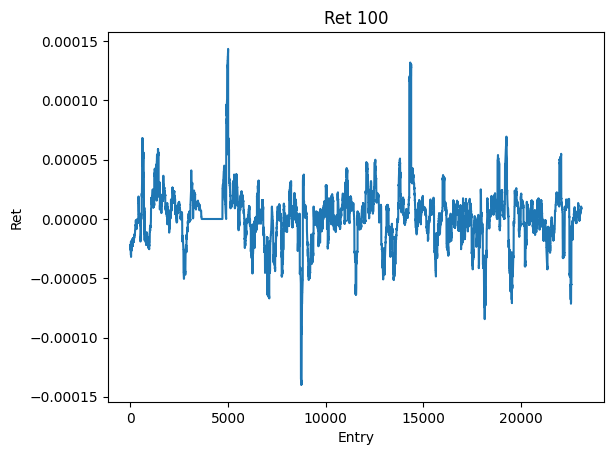

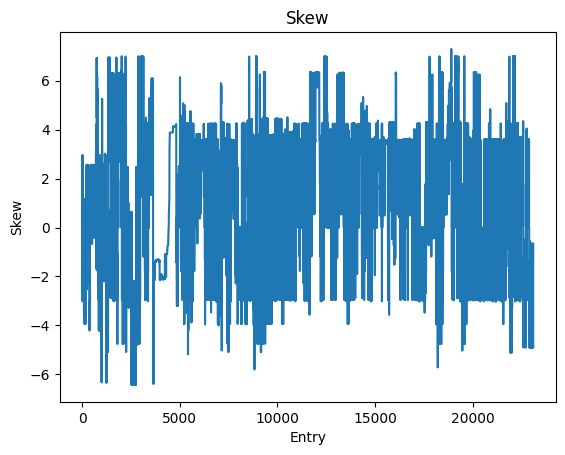

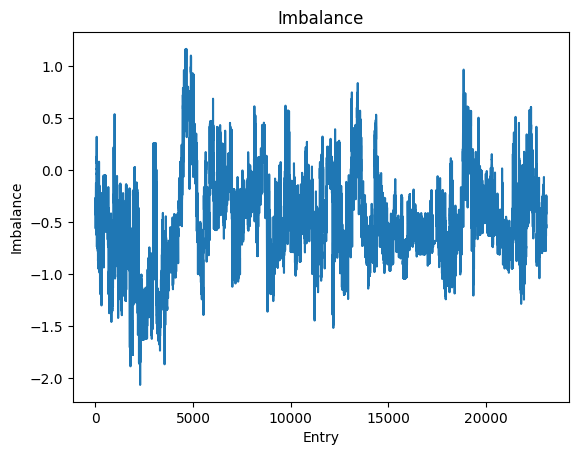

In [12]:
plt.plot(range(df.shape[0]),df['ret_100'])
plt.title('Ret 100')
plt.xlabel('Entry')
plt.ylabel('Ret')
plt.show()

plt.plot(range(df.shape[0]),df['skew'])
plt.title('Skew')
plt.xlabel('Entry')
plt.ylabel('Skew')
plt.show()

plt.plot(range(df.shape[0]),df['imbalance'])
plt.title('Imbalance')
plt.xlabel('Entry')
plt.ylabel('Imbalance')
plt.show()

# Building the Baseline Model Without PCA

In [13]:
# Create in sample and out of sample datasets
split = int(0.66 * len(df))
df_in = df.iloc[:split]
df_out = df.iloc[split:]

In [14]:
# As a simple first step check correlation. One thing to note is that order books are incredibly high noise
# environments so don't expect to see particularly high values like you might in other domains.
corr = df_in[['skew', 'imbalance', 'ret_100']].corr()
print(corr)

               skew  imbalance   ret_100
skew       1.000000   0.217988  0.119728
imbalance  0.217988   1.000000  0.058586
ret_100    0.119728   0.058586  1.000000


Now we can fit a linear regression model to each of the features individually and combinbed

In [15]:
reg = LinearRegression(fit_intercept=False, positive=True)

reg.fit(df_in[['skew']], df_in['ret_100'])
pred_skew = reg.predict(df_out[['skew']])

reg.fit(df_in[['imbalance']], df_in['ret_100'])
pred_imbalance = reg.predict(df_out[['imbalance']])

reg.fit(df_in[['skew', 'imbalance']], df_in['ret_100'])
pred_combined = reg.predict(df_out[['skew', 'imbalance']])

Next we will visualize the predictive power of our features. The cumulative PnL curve evaluates a signal's predictive power by ordering predictions from weakest to strongest and calculating cumulative returns assuming trades based on the signal's direction. Predictions are sorted by strength (value), and each corresponding return is adjusted by the prediction's sign (e.g., flipping returns for negative predictions to simulate shorting). The x-axis shows prediction strength percentiles, while the y-axis reflects cumulative PnL. If our model had true predictive power, we would expect a smoothly rising curve.

In [16]:
pct = np.arange(0, 100, step=100/len(df_out))

def get_cumulative_markout_pnl(pred):
    df_pnl = pd.DataFrame({'pred': pred, 'ret_100': df_out['ret_100'].values})
    df_pnl.loc[df_pnl['pred'] < 0, 'ret_100'] *= -1
    df_pnl = df_pnl.sort_values(by='pred')
    return df_pnl['ret_100'].cumsum().values

results = pd.DataFrame({
    'pct': pct,
    'skew': get_cumulative_markout_pnl(pred_skew),
    'imbalance': get_cumulative_markout_pnl(pred_imbalance),
    'combined': get_cumulative_markout_pnl(pred_combined),
})

fig = px.line(
    results, x='pct', y=['skew', 'imbalance', 'combined'],
    title='Forecasting with book skew vs. imbalance',
    labels={'pct': 'Predictor value (percentile)'},
)

fig.update_yaxes(title_text='Cumulative return')

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

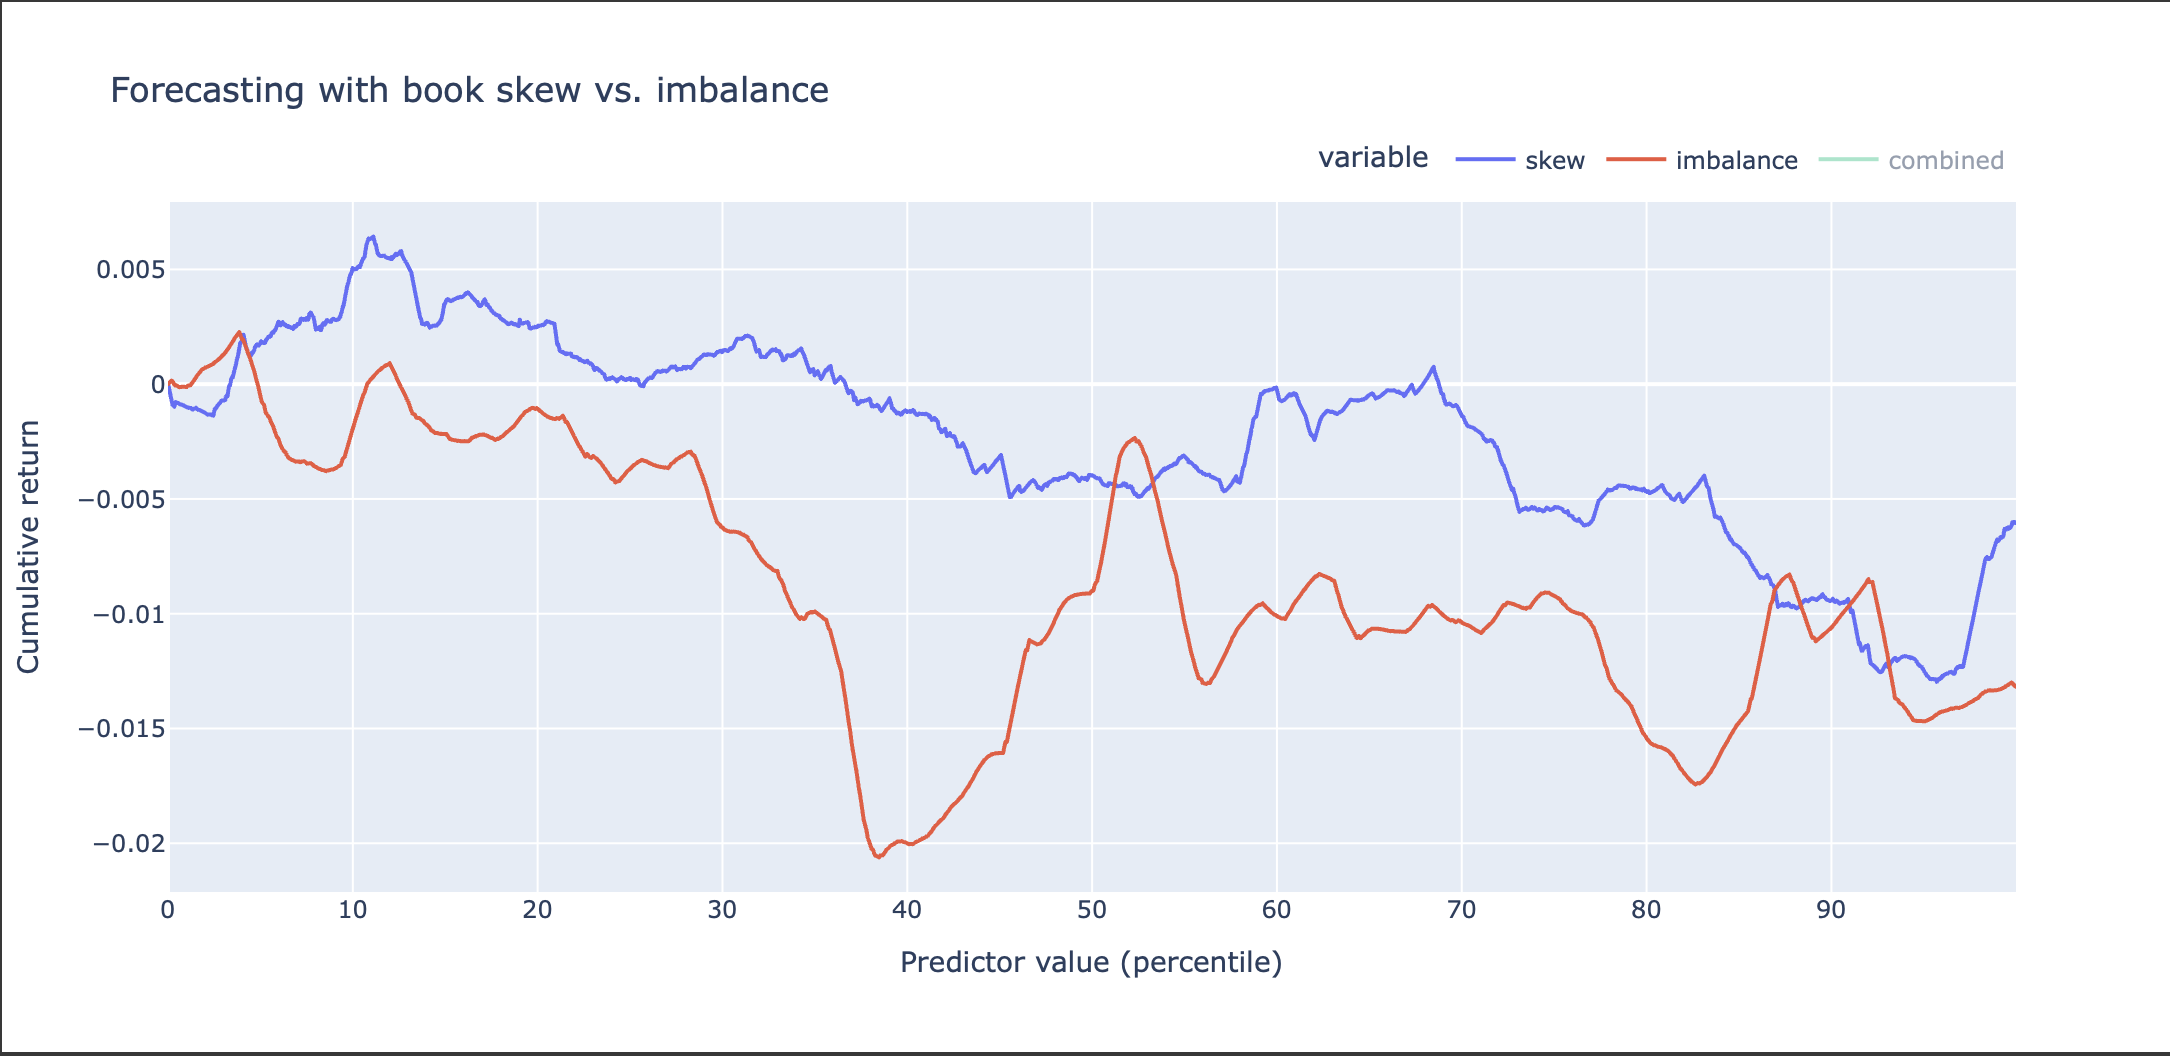

The combined and skew lines nearly overlap in this visualization so combined has been hidden for visual clarity. As we can see from the visualization these features alone show poor predictive value. Instead of higher predictor value being associated with more profitable returns, we actually see a jagged and often negative relationship. If you were to try and trade on these features alone you would likely lose out, and that is even before we include other issues like platform fees.

In [17]:
print("Mean Absolute Error:", mean_absolute_error(df_out['ret_100'].values, pred_combined))

Mean Absolute Error: 1.5604627317296472e-05


One obvious thing you might try is to simply adjust the markout period. Maybe our siginal only has short lived predictive power and waiting 100 updates is far too long?

Here the code has been refactored to take a markout variable instead of the fixed 100 value.

In [18]:
markout = 10

df = pd.DataFrame(orderbook.snapshots)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = expand_bids_asks(df, 'bids', depth=10)
df = expand_bids_asks(df, 'asks', depth=10)
df = df.drop(columns=['bids', 'asks'])
df['mid'] = (df['bids_0_price'] + df['asks_0_price']) / 2
df[f'ret_{markout}'] = df['mid'].shift(-markout) - df['mid']
df.dropna(inplace=True)
df['skew'] = np.log(df.bids_0_qty) - np.log(df.asks_0_qty)
df['imbalance'] = np.log(df[list(df.filter(regex='bids_[0-9]_qty'))].sum(axis=1)) - \
    np.log(df[list(df.filter(regex='asks_[0-9]_qty'))].sum(axis=1))
split = int(0.66 * len(df))
split -= split % 100
df_in = df.iloc[:split]
df_out = df.iloc[split:]
reg = LinearRegression(fit_intercept=False, positive=True)

reg.fit(df_in[['skew']], df_in[f'ret_{markout}'])
pred_skew = reg.predict(df_out[['skew']])

reg.fit(df_in[['imbalance']], df_in[f'ret_{markout}'])
pred_imbalance = reg.predict(df_out[['imbalance']])

reg.fit(df_in[['skew', 'imbalance']], df_in[f'ret_{markout}'])
pred_combined = reg.predict(df_out[['skew', 'imbalance']])
pct = np.arange(0, 100, step=100/len(df_out))

def get_cumulative_markout_pnl(pred):
    df_pnl = pd.DataFrame({'pred': pred, f'ret_{markout}': df_out[f'ret_{markout}'].values})
    df_pnl.loc[df_pnl['pred'] < 0, f'ret_{markout}'] *= -1
    df_pnl = df_pnl.sort_values(by='pred')
    return df_pnl[f'ret_{markout}'].cumsum().values

results = pd.DataFrame({
    'pct': pct,
    'skew': get_cumulative_markout_pnl(pred_skew),
    'imbalance': get_cumulative_markout_pnl(pred_imbalance),
    'combined': get_cumulative_markout_pnl(pred_combined),
})

fig = px.line(
    results, x='pct', y=['skew', 'imbalance', 'combined'],
    title='Forecasting with book skew vs. imbalance',
    labels={'pct': 'Predictor value (percentile)'},
)

fig.update_yaxes(title_text='Cumulative return')

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

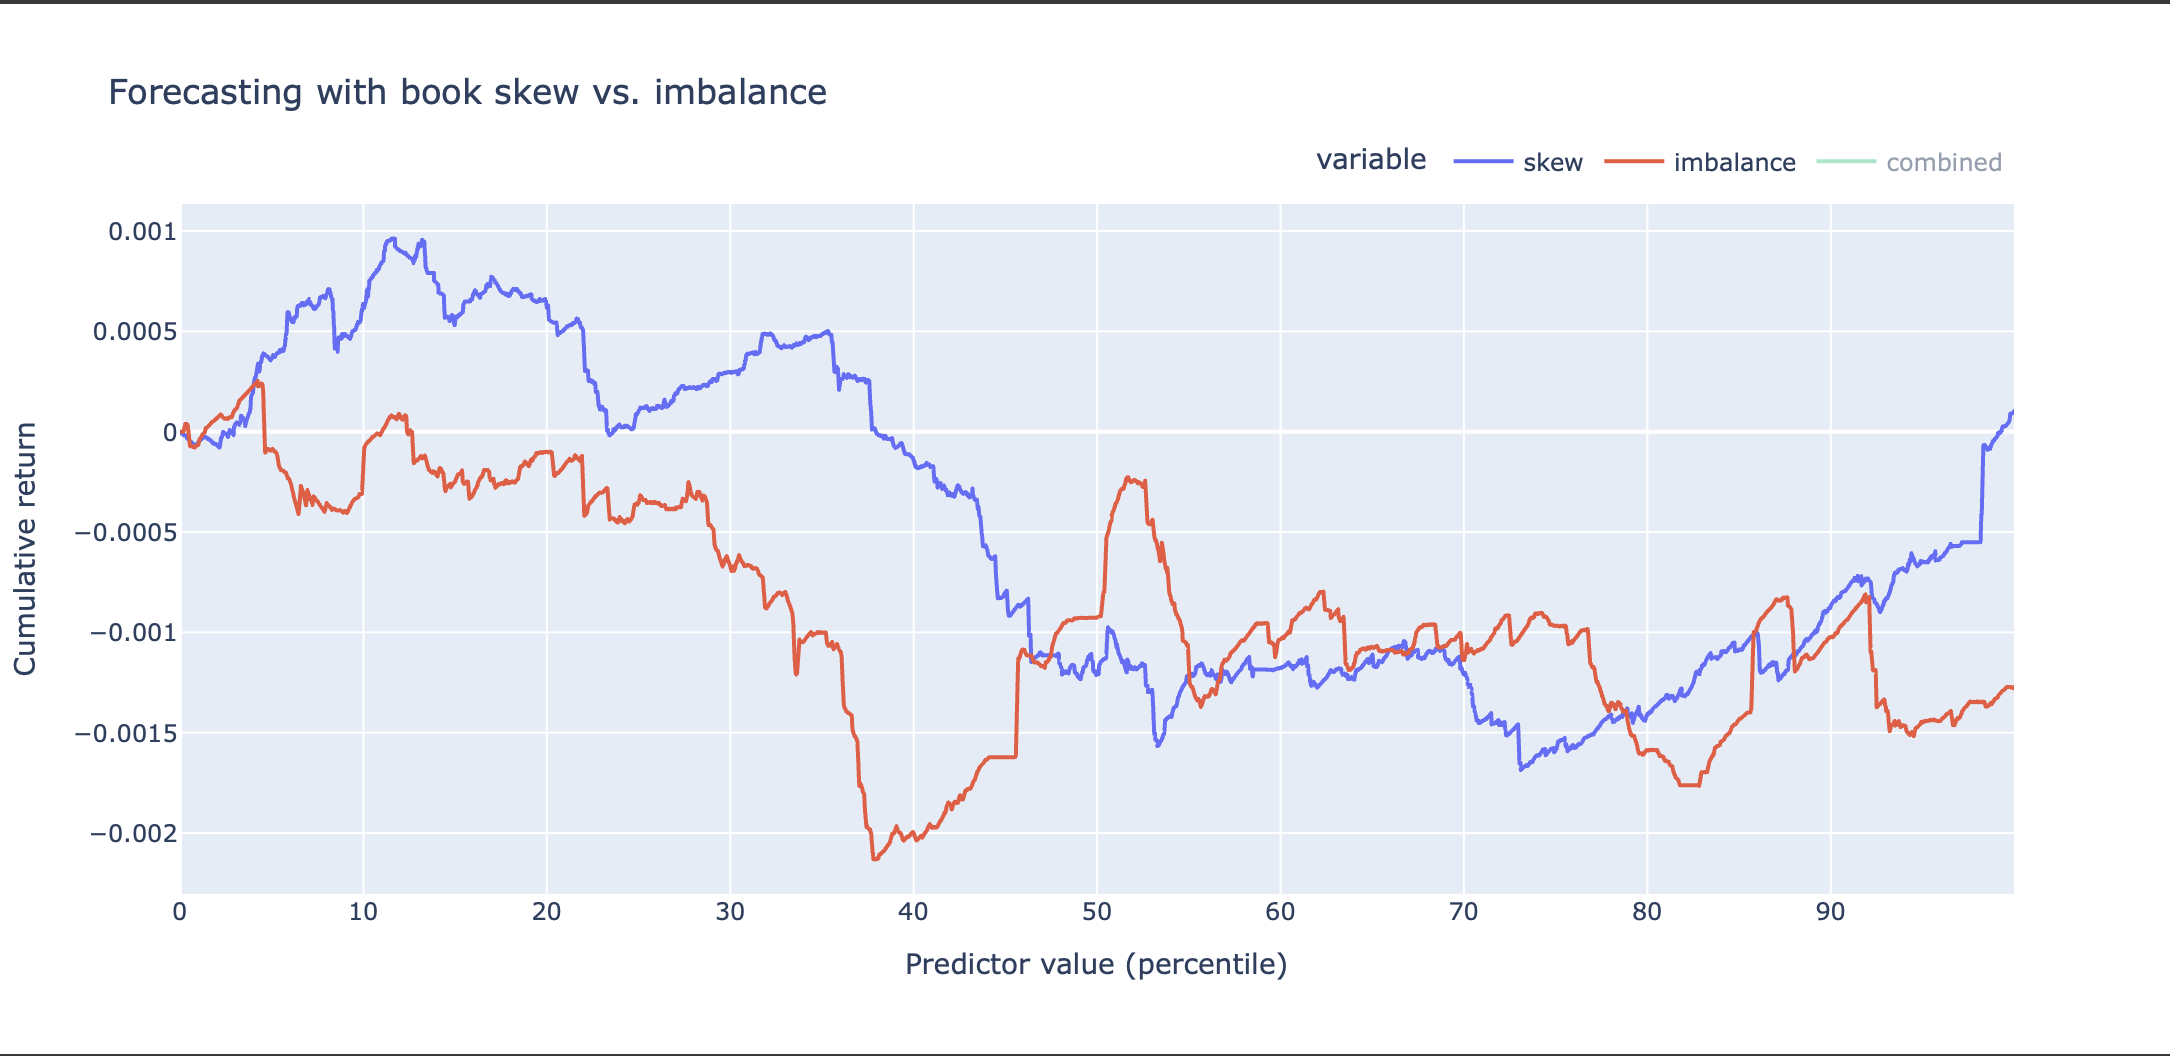

Unfortunately, it looks like this shorter interval didn't solve our problems. Lets see if unsupervised techniques, namely PCA, can improve our results.

## Unsuperviser Learning to Improve Model Performance

We will now implement a regression model that incorporates PCA.

In [19]:
# Similarly to the pure supervised version we will turn the orderbook snapshots into a dataframe

markout = 100

df = pd.DataFrame(orderbook.snapshots)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = expand_bids_asks(df, 'bids', depth=10)
df = expand_bids_asks(df, 'asks', depth=10)
df = df.drop(columns=['bids', 'asks'])

cols_to_check = [f'{side}_{i}_{ptype}' for side in ['bids', 'asks'] for i in range(10) for ptype in ['price', 'qty']]
df.dropna(subset=cols_to_check, inplace=True)

We will once again construct our initial features and markout prices

In [20]:
df['mid'] = (df['bids_0_price'] + df['asks_0_price']) / 2
df[f'ret_{markout}'] = df['mid'].shift(-markout) - df['mid']

df['skew'] = np.log(df.bids_0_qty) - np.log(df.asks_0_qty)
df['imbalance'] = np.log(df[list(df.filter(regex='bids_[0-9]_qty'))].sum(axis=1)) - \
    np.log(df[list(df.filter(regex='asks_[0-9]_qty'))].sum(axis=1))

Now we will do some additional feature engineering to prepare our price and qty values for PCA analysis

In [21]:
# Define features for PCA
pca_feature_cols = []
for i in range(10):
    # Use log quantities to stabilize variance
    df[f'bids_{i}_log_qty'] = np.log(df[f'bids_{i}_qty'])
    df[f'asks_{i}_log_qty'] = np.log(df[f'asks_{i}_qty'])
    # Use price relative to mid
    df[f'bids_{i}_rel_price'] = (df[f'bids_{i}_price'] - df['mid'])
    df[f'asks_{i}_rel_price'] = (df[f'asks_{i}_price'] - df['mid'])
    pca_feature_cols.extend([
        f'bids_{i}_log_qty', f'asks_{i}_log_qty',
        f'bids_{i}_rel_price', f'asks_{i}_rel_price'
    ])

Similar to before we need to drop rows with NaN values as a result of the shifts and split into in and out of sample datasets

In [22]:
# Drop rows with NaNs created by feature engineering or shift
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# split data into in and out of sample sets agian
split = int(0.66 * len(df))

df_in = df.iloc[:split].copy()
df_out = df.iloc[split:].copy()

With the preprocessing complete we can apply the unsupervised learning step

In [23]:
# Unsupervised Step: PCA
# Standardize the selected features
scaler = StandardScaler()
df_in_pca_features_scaled = scaler.fit_transform(df_in[pca_feature_cols])
df_out_pca_features_scaled = scaler.transform(df_out[pca_feature_cols])

# Apply PCA
n_components = 5
pca = PCA(n_components=n_components)
pca_in = pca.fit_transform(df_in_pca_features_scaled)
pca_out = pca.transform(df_out_pca_features_scaled)

print(f"Explained variance ratio by {n_components} components: {pca.explained_variance_ratio_.sum():.3f}")

Explained variance ratio by 5 components: 0.546


We now need to add the PCA components as features for our regression model and run the fit and predict stages

In [24]:
# Add PCA components as features
pca_cols = [f'pca_{i}' for i in range(n_components)]
df_in[pca_cols] = pca_in
df_out[pca_cols] = pca_out

reg = LinearRegression(fit_intercept=False, positive=True)

# Original models
reg.fit(df_in[['skew']], df_in[f'ret_{markout}'])
pred_skew = reg.predict(df_out[['skew']])

reg.fit(df_in[['imbalance']], df_in[f'ret_{markout}'])
pred_imbalance = reg.predict(df_out[['imbalance']])

reg.fit(df_in[['skew', 'imbalance']], df_in[f'ret_{markout}'])
pred_combined = reg.predict(df_out[['skew', 'imbalance']])

# New model using PCA features
reg.fit(df_in[pca_cols], df_in[f'ret_{markout}'])
pred_pca = reg.predict(df_out[pca_cols])

# New model combining original features and PCA features
combined_pca_cols = ['skew', 'imbalance'] + pca_cols
reg.fit(df_in[combined_pca_cols], df_in[f'ret_{markout}'])
pred_combined_pca = reg.predict(df_out[combined_pca_cols])

We can now plot a cumulative PnL curve for the new and combined PCA feature models

In [25]:
pct = np.arange(0, 100, step=100/len(df_out))


def get_cumulative_markout_pnl(pred, actual_ret_series):
    df_pnl = pd.DataFrame({'pred': pred, f'ret_{markout}': actual_ret_series.values})
    df_pnl.loc[df_pnl['pred'] < 0, f'ret_{markout}'] *= -1 # Only has effect if positive=False
    df_pnl = df_pnl.sort_values(by='pred')
    return df_pnl[f'ret_{markout}'].cumsum().values

actual_returns_out = df_out[f'ret_{markout}']

results = pd.DataFrame({
    'pct': pct,
    'skew': get_cumulative_markout_pnl(pred_skew, actual_returns_out),
    'imbalance': get_cumulative_markout_pnl(pred_imbalance, actual_returns_out),
    'combined': get_cumulative_markout_pnl(pred_combined, actual_returns_out),
    'pca': get_cumulative_markout_pnl(pred_pca, actual_returns_out),
    'combined_pca': get_cumulative_markout_pnl(pred_combined_pca, actual_returns_out),
})

fig = px.line(
    results, x='pct', y=['skew', 'imbalance', 'combined', 'pca', 'combined_pca'],
    title='Forecasting with book skew, imbalance, and PCA features',
    labels={'pct': 'Predictor value (percentile equivalent via sorting)', 'value': 'Cumulative Return'}, # Renamed y axis label
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

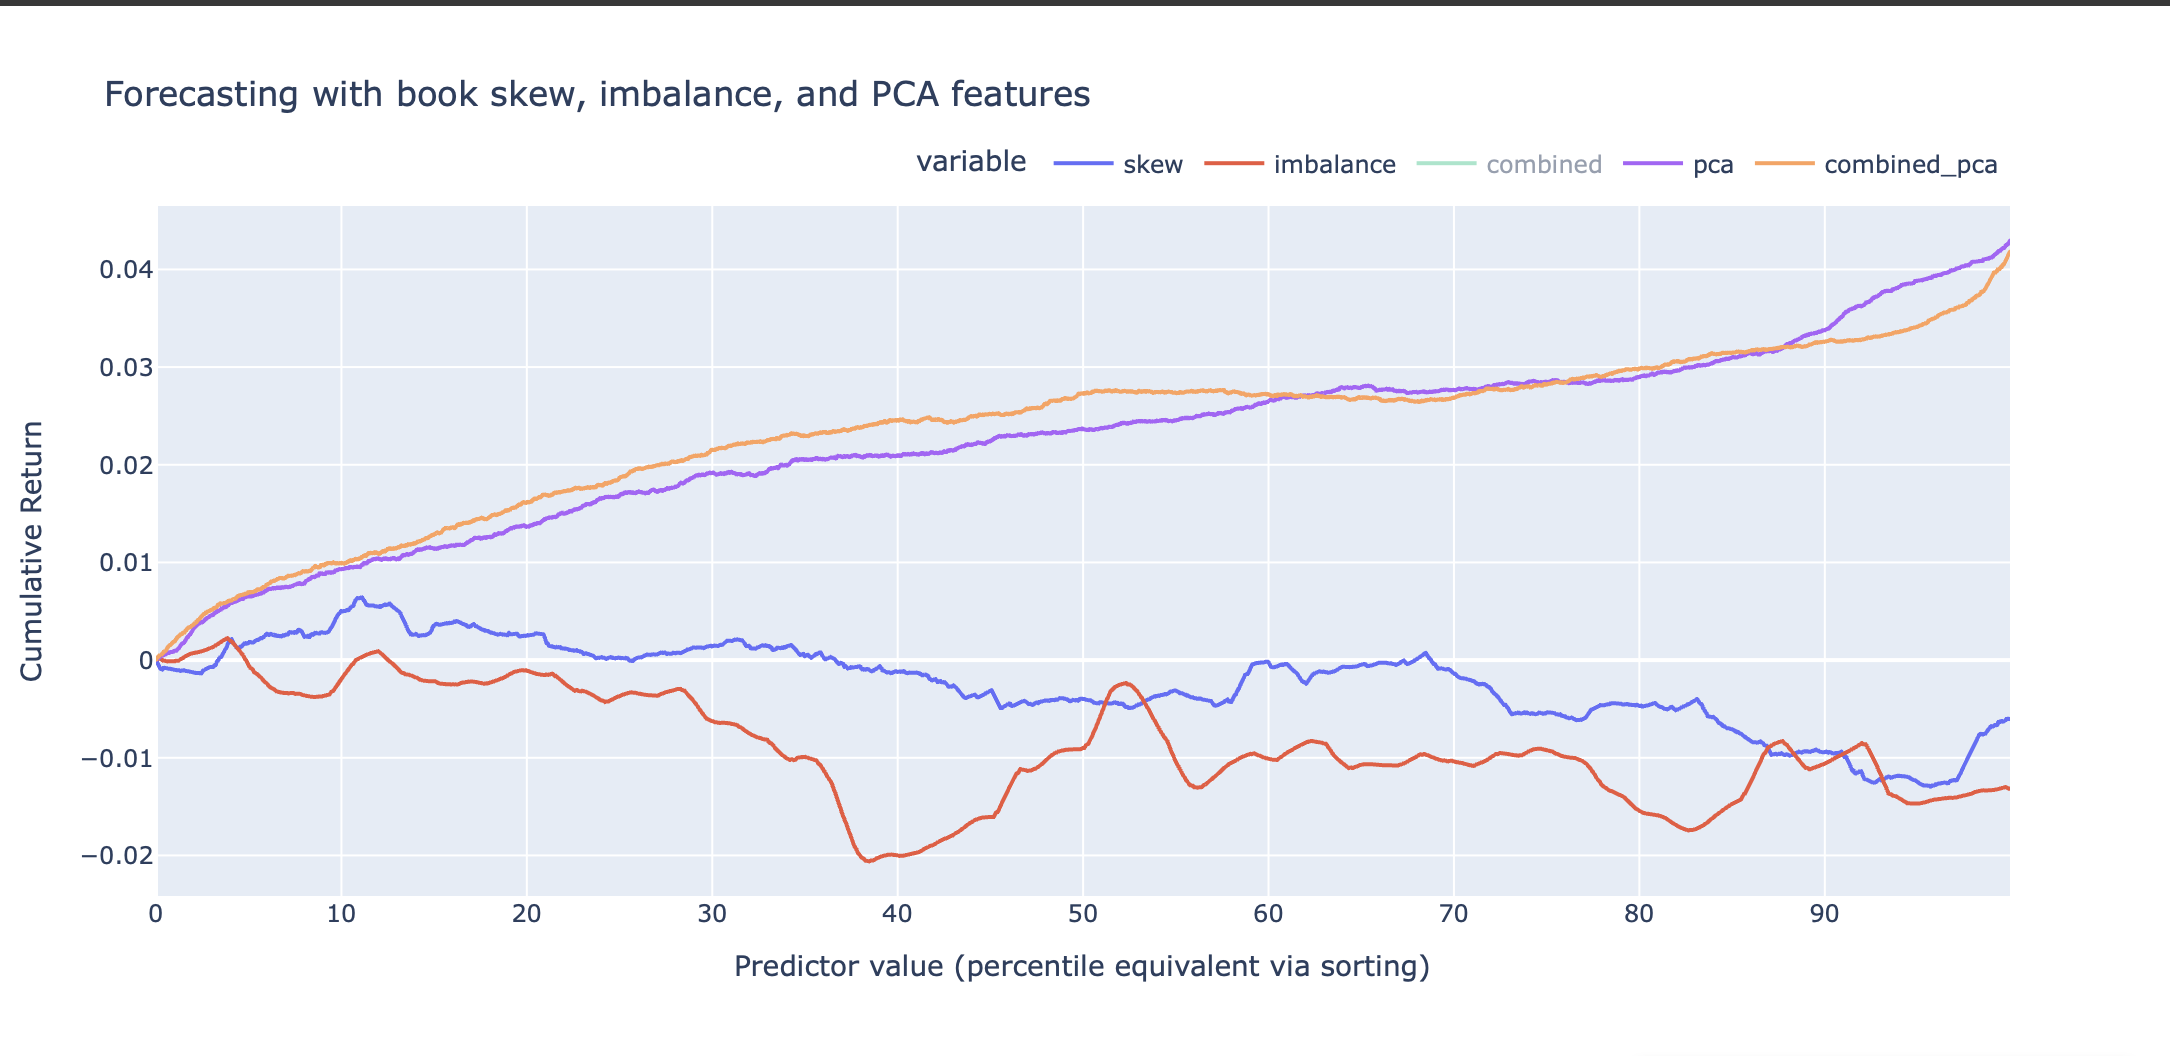

We can see from this visualization that the new model incorporating unsupervised techniques has far better predictive power than our original skew and imbalance models.

In [26]:
print("Mean Absolute Error:", mean_absolute_error(actual_returns_out.values, pred_combined_pca))

Mean Absolute Error: 1.4866949532980312e-05


# Conclusion

So should you go and trade on this signal...no I can't say I recommend it. This model is missing one key dynamic from real-world order books, time priority. In most markets, order books follow a price-time priority model. That is to say higher bids (lower asks) have priority over lower bids (higher asks) so for example a bid for \$100 would get filled before a bid for \$99. However, there is a second axis time that determines who gets filled within a given price level. So if you want to buy at \$100 but another person already has an order in to buy at \$100 you would be behind them in the que. This means that even if you knew with perfect certainty where the order book was headed (which you don't), if another market participant beats you to submitting an order you might not actually get filled on your order. This ties in closely with the concept of adverse selection and conditional probability. Conditional on your order getting filled what is the new likelihood that you like that price level. Well given that everyone else must have pulled their orders out of the way for you to get filled, not very high. This means you are constantly getting filled when your predictions are wrong and not getting filled when your predictions are correct. This project does however show that utilizing unsupervised learning is a powerful tool for improving models especially in high-dimensional environments like financial data. PCA features proved a valuable addition to just using simple measures like skew and imbalance. Using additional techniques to blend this signal as one of many inputs into a larger predictive framework can be a good inital step to developing a trading model.

# Future Work

Using high-frequency data sources is both a blessing and a curse for modeling work. On one hand it is relatively easy to acquire more data but on the other it can be hard to know where to stop and avoid filling up your storage. Additionally, during the model construction stage you may need to switch to batch processing if the whole dataframe cannot fit in RAM. This complicates the development process and slows your ability to iterate. For this project I chose to use only one hour of data but in the future it would be nice to save down multiple days worth and expand my analysis. Additionally this work featured only a single asset but it is easy to image that other order books would have different pricing and liquidity dynamics.